<a href="https://colab.research.google.com/github/Rugiyya1/Churn_analysis_of_a_Bank_Kaggle_competition/blob/main/Binary_classification_with_a_bank_churn_dataset_Kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [ ]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer

In [ ]:
train_df = pd.read_csv('/content/train.csv', index_col='id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1,0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1,1,49503.50,0
2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1,0,184866.69,0
3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1,1,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1,1,15068.83,0


In [ ]:
test_df = pd.read_csv('/content/test.csv', index_col='id').astype({'IsActiveMember' : np.uint8, 'HasCrCard' : np.uint8})
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.00,2,0.00,2,0,1,160976.75
165035,15782418,Nott,683,France,Female,46.00,2,0.00,1,1,0,72549.27
165036,15807120,K?,656,France,Female,34.00,7,0.00,2,1,0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.00,8,0.00,1,1,0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.00,10,121263.62,1,1,0,139431.00


#Data Preprocessing

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  uint8  
 10  IsActiveMember   165034 non-null  uint8  
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(3), int64(5), object(3), uint8(2)
memory usage: 15.4+ MB


In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165034.00,15692005.02,71397.82,15565701.00,15633141.00,15690169.00,15756824.00,15815690.00
CreditScore,165034.00,656.45,80.10,350.00,597.00,659.00,710.00,850.00
Age,165034.00,38.13,8.87,18.00,32.00,37.00,42.00,92.00
Tenure,165034.00,5.02,2.81,0.00,3.00,5.00,7.00,10.00
Balance,165034.00,55478.09,62817.66,0.00,0.00,0.00,119939.52,250898.09
NumOfProducts,165034.00,1.55,0.55,1.00,1.00,2.00,2.00,4.00
HasCrCard,165034.00,0.75,0.43,0.00,1.00,1.00,1.00,1.00
IsActiveMember,165034.00,0.50,0.50,0.00,0.00,0.00,1.00,1.00
EstimatedSalary,165034.00,112574.82,50292.87,11.58,74637.57,117948.00,155152.47,199992.48
Exited,165034.00,0.21,0.41,0.00,0.00,0.00,0.00,1.00


In [ ]:
## Personalizing description of data

desc = pd.DataFrame(index = list(train_df))
desc['type'] = train_df.dtypes
desc['count'] = train_df.count()
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] / len(train_df) * 100
desc['null'] = train_df.isnull().sum()
desc['%null'] = desc['null'] / len(train_df) * 100
desc['min'] = train_df.min()
desc['max'] = train_df.max()
desc


,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.07,0,0.00,15565701,15815690
Surname,object,165034,2797,1.69,0,0.00,Abazu,Zuyeva
CreditScore,int64,165034,457,0.28,0,0.00,350,850
Geography,object,165034,3,0.00,0,0.00,France,Spain
Gender,object,165034,2,0.00,0,0.00,Female,Male
Age,float64,165034,71,0.04,0,0.00,18.00,92.00
Tenure,int64,165034,11,0.01,0,0.00,0,10
Balance,float64,165034,30075,18.22,0,0.00,0.00,250898.09
NumOfProducts,int64,165034,4,0.00,0,0.00,1,4
HasCrCard,uint8,165034,2,0.00,0,0.00,0,1


In [ ]:
numerical_features = list(test_df._get_numeric_data())
categorical_features = list(test_df.drop(numerical_features, axis = 1))

#EDA

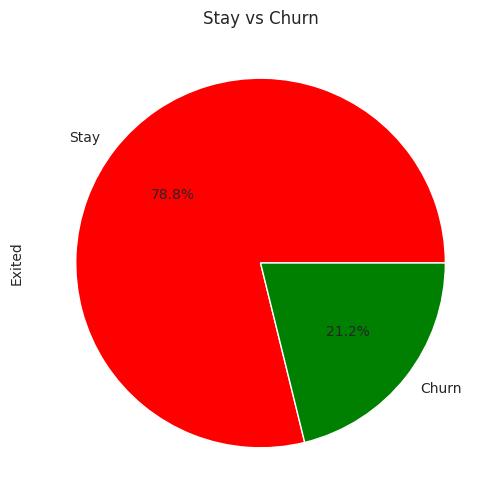

In [ ]:
train_df['Exited'].value_counts().plot.pie(autopct ='%.1f%%', colors =['r', 'g'], labels = ['Stay', 'Churn'])
plt.title('Stay vs Churn')
plt.show()

In [ ]:
## as visible, data is slightly imbalanced and will probably need to be treated

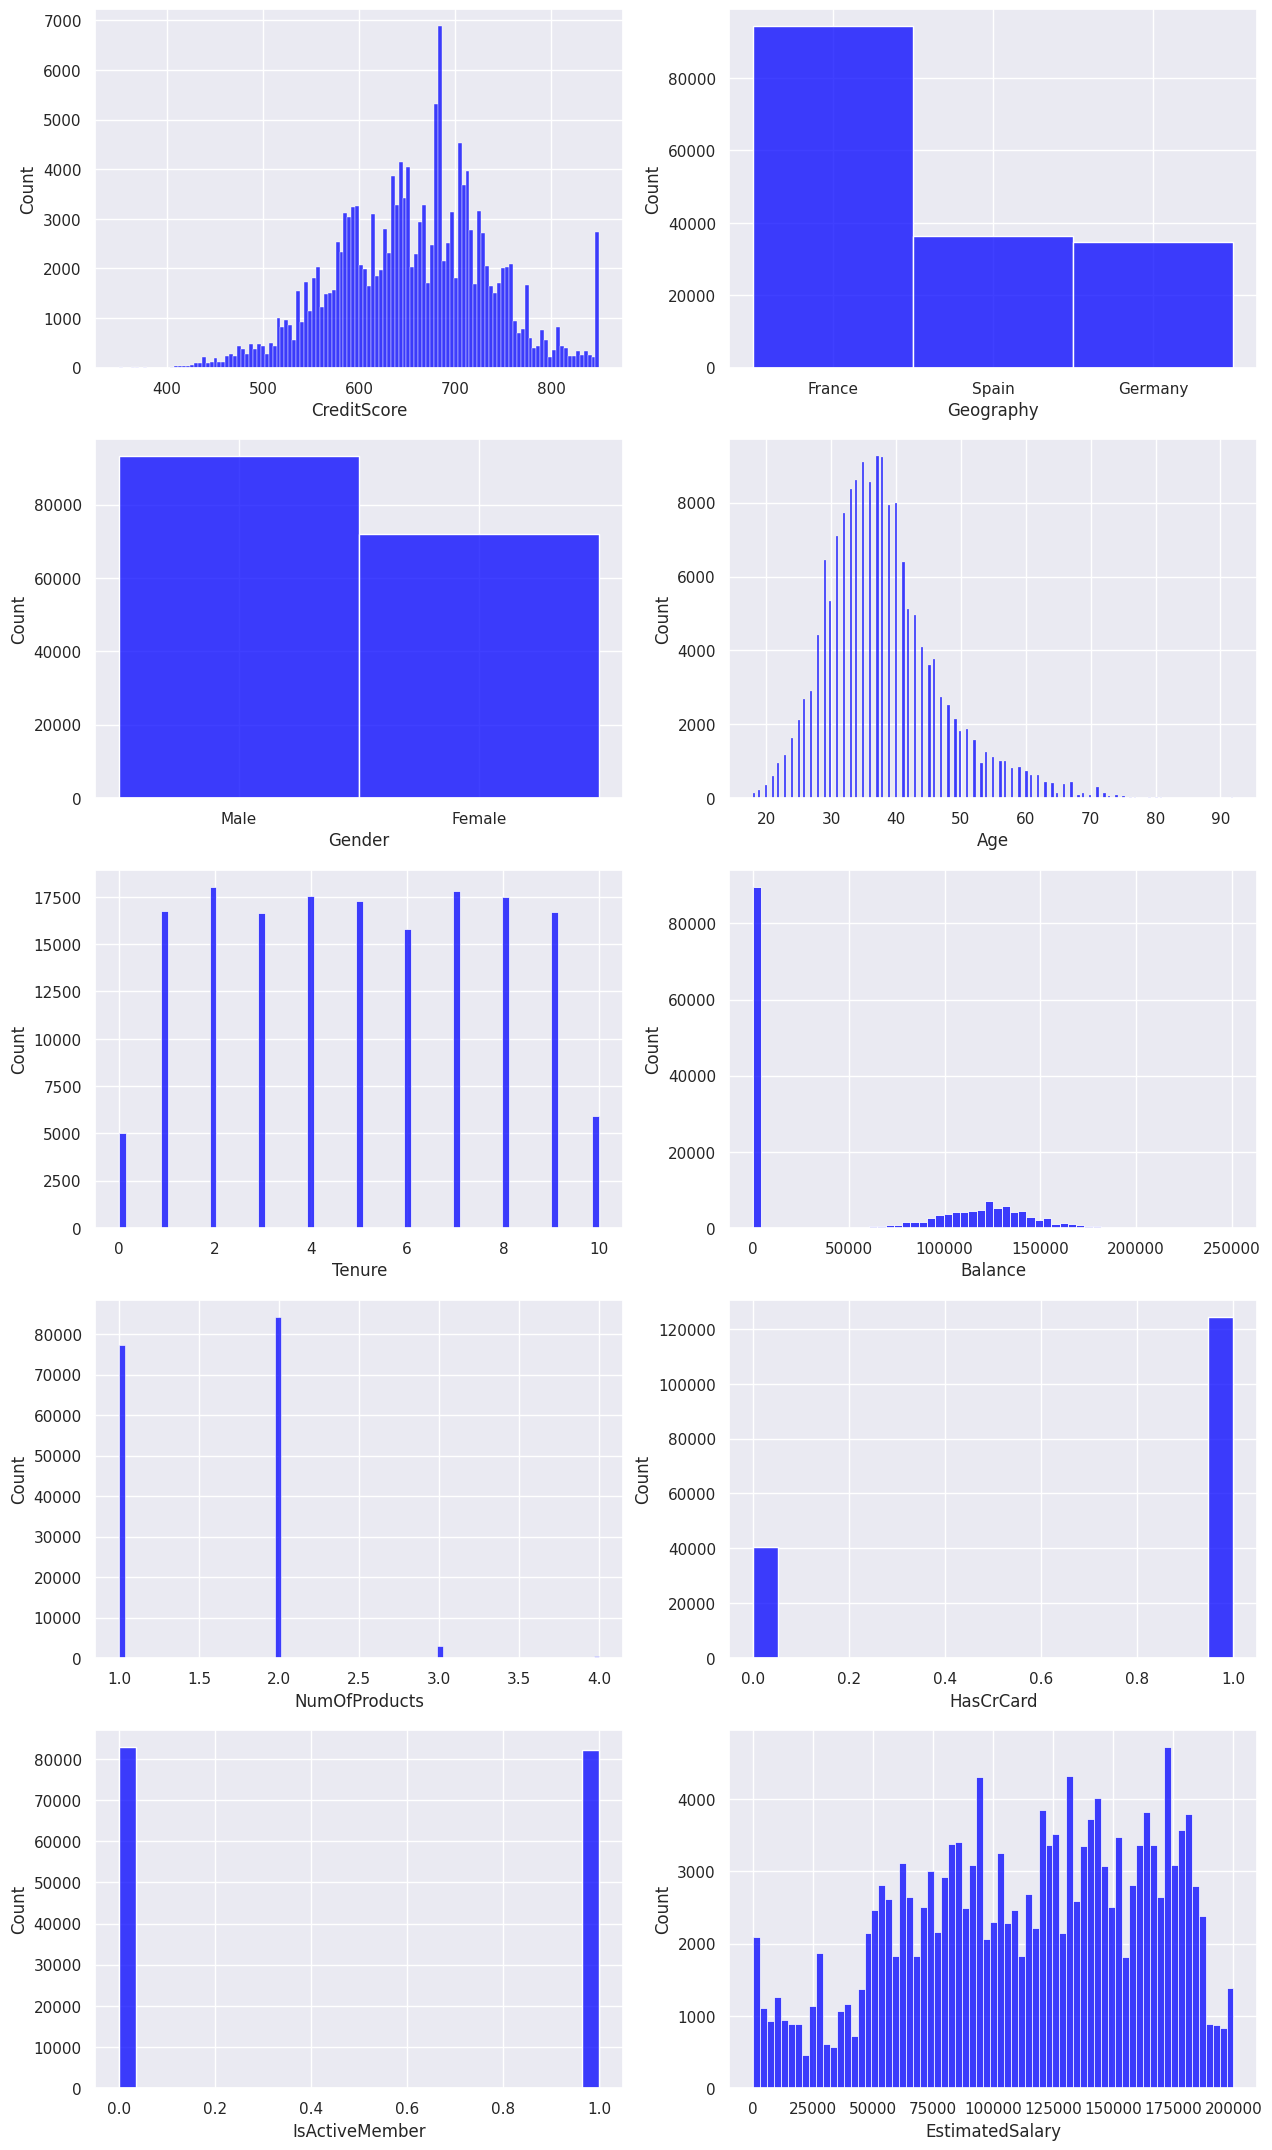

In [ ]:
fig, axs = plt.subplots(nrows =5, ncols =2,figsize=(15,27))
axs = axs.flatten()

ds= train_df.loc[:, 'CreditScore':'EstimatedSalary']

for i, var in enumerate(ds.columns.tolist()):

  sns.histplot(x =var, data =ds, ax =axs[i], color='blue')
  #axs[i].set_title(var)
  axs[i].tick_params(axis='x', rotation =0)



# Show plot
plt.show()

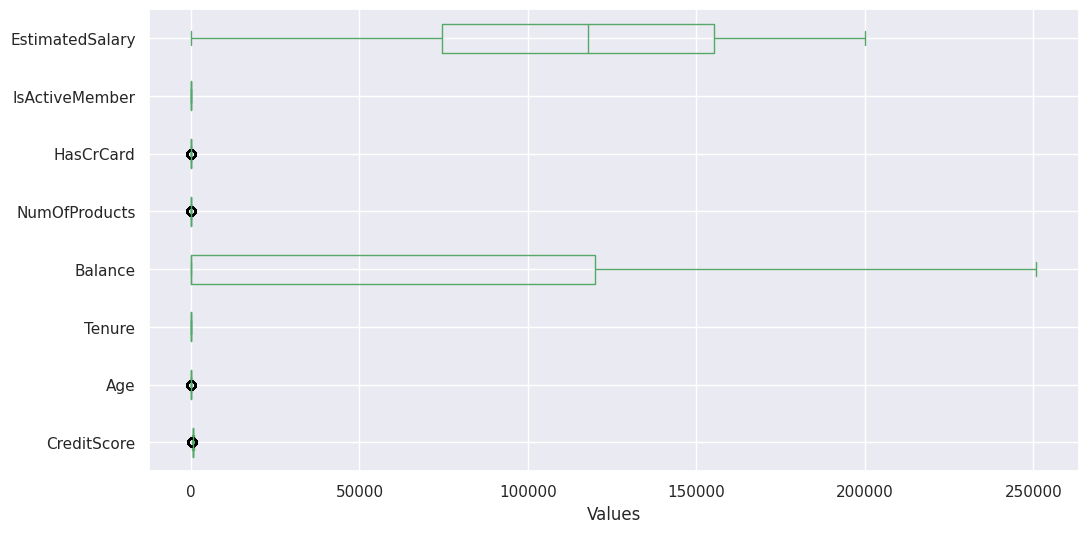

In [ ]:
## Boxplot

ds.boxplot(vert=False, color= 'g')
plt.xlabel('Values')
plt.show()

In [ ]:
# there are outliers in some features. Balance and Age will be treated from right side of their distrubutions, CreditScore will be treated from left side of its distribution

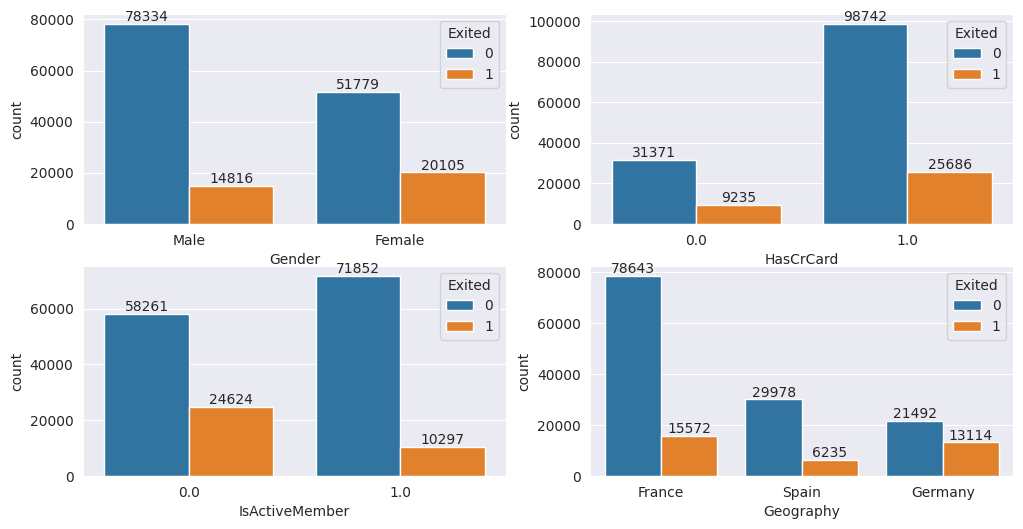

In [ ]:
cols = ['Gender', 'HasCrCard', 'IsActiveMember', 'Geography' ]

fig, axs = plt.subplots(nrows =2, ncols =2)
axs = axs.flatten()

for i, col in enumerate(train_df[cols]):
  ax = sns.countplot(data = train_df, x=col, ax=axs[i], hue = train_df["Exited"])
  for i in ax.containers: ax.bar_label(i)

<Axes: >

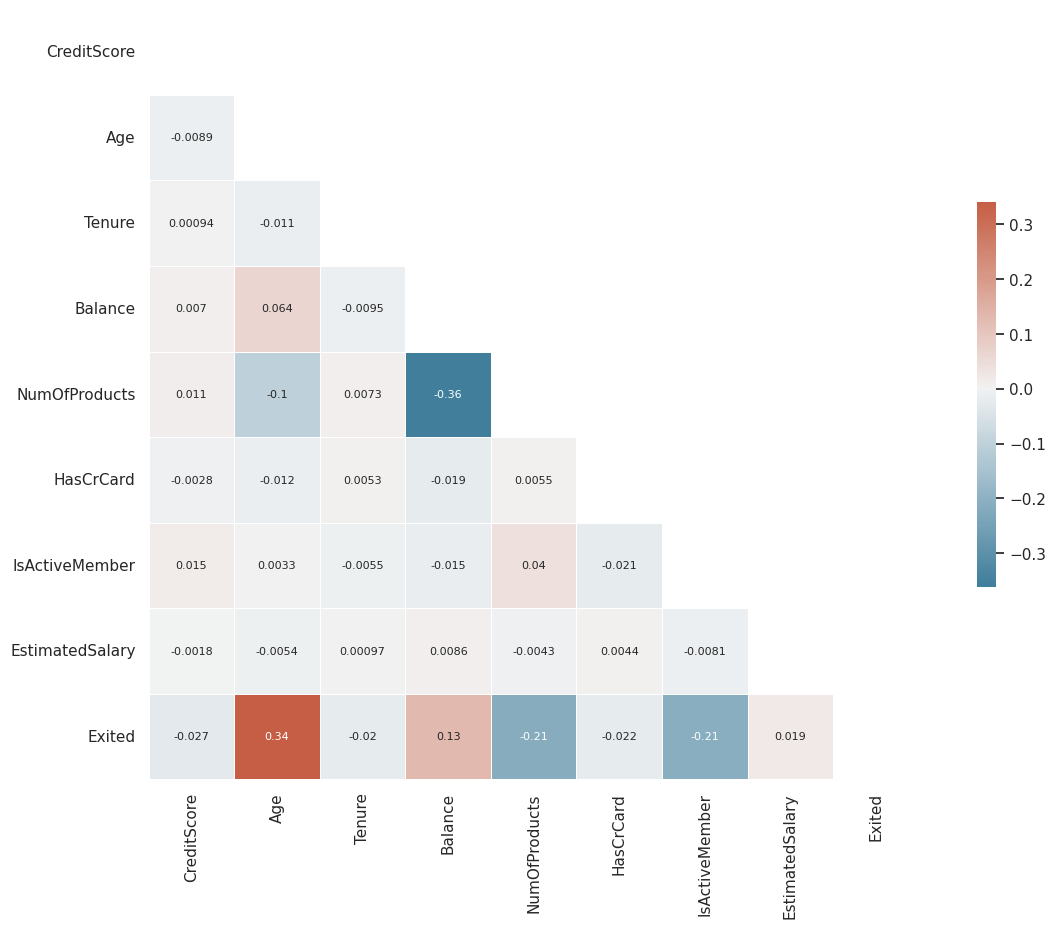

In [ ]:
## Checking correlation between features
sns.set_theme(style='white')

corr =train_df.corr()

mask = np.triu(np.ones_like(corr, dtype =bool))

f,ax = plt.subplots(figsize=(15, 10))

cmap =sns.diverging_palette(230,20, as_cmap =True)


sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":8})

In [ ]:
correlation = train_df.corr()
correlation['Exited'].sort_values(ascending=True)

NumOfProducts     -0.21
IsActiveMember    -0.21
CreditScore       -0.03
HasCrCard         -0.02
Tenure            -0.02
EstimatedSalary    0.02
Balance            0.13
Age                0.34
Exited             1.00
Name: Exited, dtype: float64

Insights based on EDA:
- No missing values
- Data is an imbalanced data
- Some features has no value and should be dropped (like RowNumber, CustomerId,and Surname)
- Correlations between features are quite low and acceptable
- Age and Balance has high positive corrleation with Customer Churn
- Active members are less likly to leave (negative corr)



#Preparation

In [ ]:
X =  train_df
y = X.pop('Exited')



# Feature Engineering

In [ ]:
def nullify(x):
    x_copy = x.copy()
    x_copy['Balance'] = x_copy['Balance'].replace({0 : np.nan})
    return x_copy

Nullify = FunctionTransformer(nullify)

EstimatedSalary and Age as integer by multiplying them by 100 and 10 respectively

In [ ]:
def salary_rounder(x):
    x_copy = x.copy()
    x_copy['EstimatedSalary'] = (x_copy['EstimatedSalary'] * 100).astype(np.uint64)
    return x_copy

SalaryRounder = FunctionTransformer(salary_rounder)

In [ ]:
def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age'] * 10).astype(np.uint16)
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)

In [ ]:
def balance_rounder(x):
    x_copy = x.copy()
    x_copy['Balance'] = (x_copy['Balance'] * 100).astype(np.uint64)
    return x_copy

BalanceRounder = FunctionTransformer(balance_rounder)

In [ ]:
def feature_generator(x):

    x_copy = x.copy()
    #x_copy['IsSenior'] = (x_copy['Age'] >= 600).astype(np.uint8)
    x_copy['IsActive_by_CreditCard'] = x_copy['HasCrCard'] * x_copy['IsActiveMember']
    x_copy['Products_Per_Tenure'] =  x_copy['Tenure'] / x_copy['NumOfProducts']
    x_copy['ZeroBalance'] = (x_copy['Balance'] == 0).astype(np.uint8)
    x_copy['AgeCat'] = np.round(x_copy.Age/20).astype(np.uint16)#.astype('category')
    x_copy['AllCat'] = x_copy['Surname']+x_copy['Geography']+x_copy['Gender']+x_copy.EstimatedSalary.astype('str')+x_copy.CreditScore.astype('str')+x_copy.Age.astype('str')+x_copy.NumOfProducts.astype('str')+x_copy.Tenure.astype('str')+x_copy.CustomerId.astype('str')#+np.round(x_copy.IsActiveMember).astype('str')

    return x_copy

FeatureGenerator = FunctionTransformer(feature_generator)

In [ ]:
def svd_rounder(x):

    x_copy = x.copy()
    for col in [column for column in list(x) if 'SVD' in column]:
        x_copy[col] = (x_copy[col] * 1e18).astype(np.int64)

    return x_copy

SVDRounder = FunctionTransformer(svd_rounder)

In [ ]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, x, y):
        return self

    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [ ]:
class Categorizer(BaseEstimator, TransformerMixin):

    def __init__(self, cols : list):
        self.cols = cols

    def fit(self, x, y):
        return self

    def transform(self, x):
        return x.astype({cat : 'category' for cat in self.cols})

In [ ]:
class Vectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, max_features = 1000, cols = ['Surname'], n_components = 3):
        self.max_features = max_features
        self.cols = cols
        self.n_components = n_components

    def fit(self, x, y):
        self.vectorizer_dict = {}
        self.decomposer_dict = {}

        for col in self.cols:
            self.vectorizer_dict[col] = TfidfVectorizer(max_features = self.max_features).fit(x[col].astype(str), y)
            self.decomposer_dict[col] = TruncatedSVD(random_state = seed, n_components = self.n_components).fit(
                self.vectorizer_dict[col].transform(x[col].astype(str)), y
            )

        return self

    def transform(self, x):
        vectorized = {}

        for col in self.cols:
            vectorized[col] = self.vectorizer_dict[col].transform(x[col].astype(str))
            vectorized[col] = self.decomposer_dict[col].transform(vectorized[col])

        vectorized_df = pd.concat([pd.DataFrame(vectorized[col]).rename({
            f'truncatedsvd{i}' : f'{col}SVD{i}' for i in range(self.n_components)
        }, axis = 1) for col in self.cols], axis = 1)

        return pd.concat([x.reset_index(drop = True), vectorized_df], axis = 1)

# Data Processing

In [ ]:
#shape of original dataset
train_df.shape

(165034, 11)

**Treating outliers**

In [ ]:
## 1st treating balance column
upper_bound = np.percentile(train_df['Balance'], 95)
train_df = train_df[train_df['Balance'] < upper_bound]
train_df.shape

(156781, 11)

In [ ]:
#2nd treatment is done on CreditScore column
lower_bound =np.percentile(train_df['CreditScore'], 1)
lower_bound

468.0

In [ ]:
train_df = train_df[train_df['CreditScore'] > lower_bound]
train_df.shape

(155133, 11)

In [ ]:
#3rd treatment has been done on age column
upper_bound = np.percentile(train_df['Age'], 98)
upper_bound

62.0

In [ ]:
train_df = train_df[train_df['Age'] < upper_bound]
train_df.shape

(151947, 11)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
train_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0
1,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0
2,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0
3,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0
4,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
151942,630,France,Male,50.00,8,0.00,2,1.00,1.00,5962.50,0
151943,667,Spain,Female,33.00,2,0.00,1,1.00,1.00,131834.75,0
151944,792,France,Male,35.00,3,0.00,1,0.00,0.00,131834.45,0
151945,565,France,Male,31.00,5,0.00,1,1.00,1.00,127429.56,0


In [ ]:
## Encoding Categorical varaibles using OrdinalEncorder()

from sklearn.preprocessing import OneHotEncoder


one_enc=OneHotEncoder(sparse=False)

result = one_enc.fit_transform(train_df[['Gender', 'Geography']])
one_enc =pd.DataFrame(result)

## bring back column names

#ord_enc.columns=['Gender_enc', 'Geography_enc']
one_enc

,0,1,2,3,4
0,0.00,1.00,1.00,0.00,0.00
1,0.00,1.00,1.00,0.00,0.00
2,0.00,1.00,1.00,0.00,0.00
3,0.00,1.00,1.00,0.00,0.00
4,0.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...
151942,0.00,1.00,1.00,0.00,0.00
151943,1.00,0.00,0.00,0.00,1.00
151944,0.00,1.00,1.00,0.00,0.00
151945,0.00,1.00,1.00,0.00,0.00


In [ ]:
## Encoding Categorical varaibles using OrdinalEncorder()

from sklearn.preprocessing import OrdinalEncoder

data = np.asarray(train_df[['Gender', 'Geography']])

encoder=OrdinalEncoder()

result = encoder.fit_transform(data)
ord_enc =pd.DataFrame(result)

## bring back column names

ord_enc.columns=['Gender_enc', 'Geography_enc']
ord_enc

,Gender_enc,Geography_enc
0,1.00,0.00
1,1.00,0.00
2,1.00,0.00
3,1.00,0.00
4,1.00,2.00
...,...,...
151942,1.00,0.00
151943,0.00,2.00
151944,1.00,0.00
151945,1.00,0.00


In [ ]:
processed_data = pd.concat([train_df, one_enc], axis=1)
processed_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,0,1,2,3,4
0,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0,0.00,1.00,1.00,0.00,0.00
1,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0,0.00,1.00,1.00,0.00,0.00
2,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0,0.00,1.00,1.00,0.00,0.00
3,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0,0.00,1.00,1.00,0.00,0.00
4,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0,0.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151942,630,France,Male,50.00,8,0.00,2,1.00,1.00,5962.50,0,0.00,1.00,1.00,0.00,0.00
151943,667,Spain,Female,33.00,2,0.00,1,1.00,1.00,131834.75,0,1.00,0.00,0.00,0.00,1.00
151944,792,France,Male,35.00,3,0.00,1,0.00,0.00,131834.45,0,0.00,1.00,1.00,0.00,0.00
151945,565,France,Male,31.00,5,0.00,1,1.00,1.00,127429.56,0,0.00,1.00,1.00,0.00,0.00


In [ ]:
processed_data.drop(['Geography', 'Gender'], axis=1, inplace=True)

In [ ]:
processed_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,0,1,2,3,4
0,668,33.00,3,0.00,2,1.00,0.00,181449.97,0,0.00,1.00,1.00,0.00,0.00
1,627,33.00,1,0.00,2,1.00,1.00,49503.50,0,0.00,1.00,1.00,0.00,0.00
2,678,40.00,10,0.00,2,1.00,0.00,184866.69,0,0.00,1.00,1.00,0.00,0.00
3,581,34.00,2,148882.54,1,1.00,1.00,84560.88,0,0.00,1.00,1.00,0.00,0.00
4,716,33.00,5,0.00,2,1.00,1.00,15068.83,0,0.00,1.00,0.00,0.00,1.00


In [ ]:
correlation = processed_data.corr()
correlation['Exited'].sort_values(ascending=True)

NumOfProducts     -0.23
IsActiveMember    -0.21
1                 -0.15
2                 -0.13
4                 -0.05
CreditScore       -0.03
HasCrCard         -0.02
Tenure            -0.02
EstimatedSalary    0.02
Balance            0.14
0                  0.15
3                  0.22
Age                0.38
Exited             1.00
Name: Exited, dtype: float64

In [ ]:
## Train -Test split

from sklearn.model_selection import train_test_split

X = processed_data.drop('Exited', axis=1)
y=processed_data['Exited']
X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, stratify =y)

In [ ]:
y_train.value_counts()

0    96254
1    25303
Name: Exited, dtype: int64

In [ ]:
## treating imbalance using SMOTE technique

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
X_smote.shape

(192508, 13)

In [ ]:
X_smote.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
0,727,37.00,8,0.00,2,0.00,0.00,182630.46,1.00,0.00,1.00,0.00,0.00
1,781,29.00,10,0.00,2,0.00,0.00,172097.40,0.00,1.00,1.00,0.00,0.00
2,601,41.00,5,127302.80,2,1.00,0.00,48201.64,0.00,1.00,0.00,1.00,0.00
3,769,30.00,2,0.00,2,1.00,1.00,58685.59,0.00,1.00,0.00,0.00,1.00
4,649,39.00,6,0.00,2,0.00,1.00,86767.48,0.00,1.00,1.00,0.00,0.00


In [ ]:
y_smote.value_counts()

0    96254
1    96254
Name: Exited, dtype: int64

<Axes: >

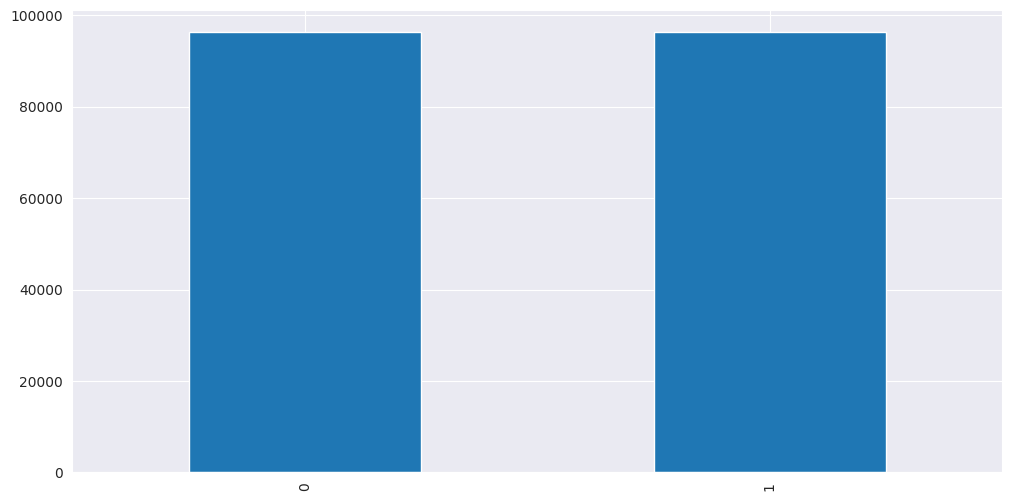

In [ ]:
y_smote.value_counts().plot.bar()

In [ ]:
##Scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [ ]:
X_smote.loc[:,'CreditScore':'EstimatedSalary'] = scaler.fit_transform(X_smote.loc[:,'CreditScore':'EstimatedSalary'])
X_smote.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
0,0.96,-0.33,1.21,-0.93,1.11,-1.85,-0.90,1.38,1.00,0.00,1.00,0.00,0.00
1,1.69,-1.33,1.97,-0.93,1.11,-1.85,-0.90,1.17,0.00,1.00,1.00,0.00,0.00
2,-0.76,0.17,0.07,1.20,1.11,0.62,-0.90,-1.30,0.00,1.00,0.00,1.00,0.00
3,1.53,-1.20,-1.06,-0.93,1.11,0.62,1.24,-1.09,0.00,1.00,0.00,0.00,1.00
4,-0.10,-0.08,0.45,-0.93,1.11,-1.85,1.24,-0.53,0.00,1.00,1.00,0.00,0.00


In [ ]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
9861,621,30.00,2,0.00,2,0.00,1.00,163516.64,0.00,1.00,1.00,0.00,0.00
38550,606,40.00,3,95293.86,2,1.00,0.00,96985.58,0.00,1.00,0.00,1.00,0.00
134501,712,22.00,2,142400.77,1,1.00,0.00,107876.20,0.00,1.00,1.00,0.00,0.00
76255,531,47.00,7,0.00,1,0.00,1.00,194998.34,0.00,1.00,1.00,0.00,0.00
17858,727,37.00,8,0.00,2,1.00,1.00,169863.80,1.00,0.00,1.00,0.00,0.00


In [ ]:
X_test.loc[:,'CreditScore':'EstimatedSalary'] =scaler.transform(X_test.loc[:,'CreditScore':'EstimatedSalary'])

In [ ]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
9861,-0.49,-1.20,-1.06,-0.93,1.11,-1.85,1.24,1.00,0.00,1.00,1.00,0.00,0.00
38550,-0.69,0.04,-0.68,0.66,1.11,0.62,-0.90,-0.33,0.00,1.00,0.00,1.00,0.00
134501,0.75,-2.20,-1.06,1.45,-0.77,0.62,-0.90,-0.11,0.00,1.00,1.00,0.00,0.00
76255,-1.71,0.91,0.83,-0.93,-0.77,-1.85,1.24,1.62,0.00,1.00,1.00,0.00,0.00
17858,0.96,-0.33,1.21,-0.93,1.11,0.62,1.24,1.12,1.00,0.00,1.00,0.00,0.00


## Model building

**Logistic Regression**

In [ ]:
log_clf =LogisticRegression(random_state=42)

log_clf.fit(X_smote, y_smote)

LogisticRegression(random_state=42)

In [ ]:
y_pred_log = log_clf.predict(X_test)

In [ ]:
print('Logistric Regression model ROC-AUC score: ', roc_auc_score(y_test, y_pred_log))

Logistric Regression model ROC-AUC score:  0.7623377850339867


**Random Forest Classifier**

In [ ]:
rnd_clf = RandomForestClassifier( random_state=42)
rnd_clf.fit(X_smote, y_smote)

RandomForestClassifier(ccp_alpha=0.001, max_leaf_nodes=16, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rnd_clf.predict(X_test)
print('Random Forest model ROC-AUC score: ', roc_auc_score(y_test, y_pred_rf))

Random Forest model ROC-AUC score:  0.7627573900833944


**Light GBM**

In [ ]:
lgbm_clf =LGBMClassifier(random_state=42)
lgbm_clf.fit(X_smote, y_smote)

[LightGBM] [Info] Number of positive: 96254, number of negative: 96254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 192508, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [ ]:
y_pred_lgbm = lgbm_clf.predict(X_test)
print('RLGBM model ROC-AUC score: ', roc_auc_score(y_test, y_pred_lgbm))

RLGBM model ROC-AUC score:  0.7732823454558526


**XGBoost**

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_smote, y_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test)
print('XGB model ROC-AUC score: ', roc_auc_score(y_test, y_pred_xgb))

XGB model ROC-AUC score:  0.7637443185544629


**Grid Search for Random forest**

In [ ]:
features_gs = {'criterion': ['entropy'],
           'max_depth': [None, 5, 10, 15], #getting more precise within range
           'min_samples_split': [2,5,10],
           'max_features': [None]}
clf = RandomForestClassifier()

gs_dt = GridSearchCV(estimator = clf, param_grid =features_gs, cv = 5, scoring ='roc_auc')

gs_dt.fit(X_smote,y_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'],
                         'max_depth': [None, 5, 10, 15], 'max_features': [None],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [ ]:
gs_dt.best_score_

0.964710099176866

In [ ]:
gs_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': None,
 'min_samples_split': 2}

In [ ]:
test_roc_auc = roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:, 1])
test_roc_auc

0.8864055669495109

In [ ]:
rnd_clf = RandomForestClassifier(criterion ='entropy', max_depth=15, max_features=None, min_samples_split=2, random_state=42)
rnd_clf.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features=None,
                       random_state=42)

In [ ]:
y_pred_rf = rnd_clf.predict(X_test)
print('Optimized Random Forest model ROC-AUC score: ', roc_auc_score(y_test, y_pred_rf))

Optimized Random Forest model ROC-AUC score:  0.7681130629733924


**Grid Search for Light GBM**

In [ ]:
features_gs = {'max_depth': [None, 5, 10, 15],
                'learning_rate': [0.05, 0.1, 0.2],
                'min_child_samples': [20,30,40],
                'n_estimators': [50, 100, 200],
           'reg_alpha' : [0, 0.1, 0.5]}
clf = LGBMClassifier(random_state=42)

gs_gbm = GridSearchCV(estimator = clf, param_grid =features_gs, cv = 5, scoring ='roc_auc')

gs_gbm.fit(X_smote,y_smote)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [None, 5, 10, 15],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.1, 0.5]},
             scoring='roc_auc')

In [ ]:
gs_gbm.best_score_

0.9697581648420857

In [ ]:
gs_gbm.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_samples': 40,
 'n_estimators': 200,
 'reg_alpha': 0.1}

In [ ]:
test_roc_auc = roc_auc_score(y_test, gs_gbm.predict_proba(X_test)[:, 1])
test_roc_auc

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


0.8917176015975524

In [ ]:
best_params = {'num_leaves':16, 'learning_rate' :0.2, 'max_depth':16, 'min_child_samples':50, 'n_estimators': 200, 'reg_alpha':0.1, 'reg_lambda':0.3}

In [ ]:
lgbm_opt = LGBMClassifier(**best_params)

In [ ]:
lgbm_opt.fit(X_smote, y_smote)

[LightGBM] [Info] Number of positive: 96254, number of negative: 96254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 192508, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.2, max_depth=16, min_child_samples=50,
               n_estimators=200, num_leaves=16, reg_alpha=0.1, reg_lambda=0.3)

In [ ]:
y_pred_lgbm = lgbm_opt.predict(X_test)
print('Optimized LGBM model ROC-AUC score: ', roc_auc_score(y_test, y_pred_lgbm))

Optimized LGBM model ROC-AUC score:  0.766977943158007


**RandomizedSearch Cv** for LGBM



In [ ]:
features_rs = { 'num_leaves' : [20,30],
                'max_depth': [-1, 5, 10, 15],
                'learning_rate': [0.05, 0.1, 0.2],
                'min_child_samples': [20,30,40],
                'n_estimators': [50, 100, 200],
                'reg_alpha' : [0, 0.1, 0.5],
                'reg_lambda':[0, 0.1, 0.5]}
clf = LGBMClassifier(random_state=42)

rs_gbm = RandomizedSearchCV(estimator = clf, param_distributions=features_rs, n_iter=100, cv = 3, scoring ='roc_auc', random_state=42)

rs_gbm.fit(X_smote,y_smote)

Streaming output truncated to the last 5000 lines.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 128339, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000016
[LightGBM] [Info] Start training from score 0.000016
[LightGBM] [Info] Number of positive: 64169, number of negative: 64170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 128339, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499996 -> initscore=-0.000016
[LightGBM] [Info] Start training from score -0.000016
[LightGBM] [Info] Number of positive: 64169, number of negative: 6

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_iter=100,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_samples': [20, 30, 40],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [20, 30],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5]},
                   random_state=42, scoring='roc_auc')

In [ ]:
rs_gbm.best_score_

0.9646368844884806

In [ ]:
rs_gbm.best_params_

{'reg_lambda': 0,
 'reg_alpha': 0.5,
 'num_leaves': 30,
 'n_estimators': 200,
 'min_child_samples': 40,
 'max_depth': -1,
 'learning_rate': 0.1}

In [ ]:
best_params = { 'learning_rate' :0.1, 'max_depth':None, 'min_child_samples':40, 'n_estimators': 200, 'reg_alpha':0.5, 'reg_lambda':0, 'num_leaves':30,'max_depth':-1}

In [ ]:
lgbm_opt = LGBMClassifier(**best_params)

In [ ]:
lgbm_opt.fit(X_smote, y_smote)

[LightGBM] [Info] Number of positive: 96254, number of negative: 96254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 192508, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(min_child_samples=40, n_estimators=200, num_leaves=30,
               reg_alpha=0.5, reg_lambda=0)

In [ ]:
y_pred_lgbm = lgbm_opt.predict(X_test)
print('Optimized LGBM model ROC-AUC score: ', roc_auc_score(y_test, y_pred_lgbm))

Optimized LGBM model ROC-AUC score:  0.7672582710726922


#Final model

In [ ]:
## Test data processing


def test_prep(df):

    test =test_df.drop(['CustomerId', 'Surname'], axis=1)

    ##getting index columns

    idx = test.index
    # ordinal encoding
    data = test[['Gender', 'Geography']]

    result = encoder.transform(data)
    one_enc =pd.DataFrame(result)

    one_enc.index=idx

    data_comb = pd.concat([test, one_enc], axis=1)

    data2 = data_comb.drop(['Geography', 'Gender'], axis=1)

    # Scaling

    data2.loc[:,'CreditScore':'EstimatedSalary'] =scaler.transform(data2.loc[:,'CreditScore':'EstimatedSalary'])

    return data2




In [ ]:
test_data =test_prep(test_df)

In [ ]:
test_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2,3,4
id,,,,,,,,,,,,,
165034,-0.97,-2.08,-1.06,-0.93,1.11,-1.85,1.25,0.95,1.00,0.00,1.00,0.00,0.00
165035,0.35,0.79,-1.06,-0.93,-0.76,0.62,-0.89,-0.81,1.00,0.00,1.00,0.00,0.00
165036,-0.02,-0.71,0.83,-0.93,1.11,0.62,-0.89,0.51,1.00,0.00,1.00,0.00,0.00
165037,0.32,-0.46,1.21,-0.93,-0.76,0.62,-0.89,0.01,0.00,1.00,1.00,0.00,0.00
165038,1.29,-0.21,1.96,1.10,-0.76,0.62,-0.89,0.52,0.00,1.00,0.00,1.00,0.00


In [ ]:
final_model = lgbm_opt

In [ ]:
y_col = final_model.predict_proba(test_data)[:,1]

In [ ]:
test_data['Prediction'] = y_col

In [ ]:
test_data['Prediction']

id
165034   0.04
165035   0.86
165036   0.03
165037   0.23
165038   0.35
         ... 
275052   0.04
275053   0.08
275054   0.02
275055   0.15
275056   0.13
Name: Prediction, Length: 110023, dtype: float64